# Training bert_multilingual Model for the Multilingual News Article Similaritis.

In [1]:
#Attach your google drive if you are running this file using google colab.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
enriched_training_dataFilePath = "/content/drive/MyDrive/enriched_training_data.csv"


In [3]:
#In case you are running this notebook using google colab then uncomment the below lines otherwiese make sure it is installed in your system if running using VS code.

!pip install transformers #installing transformers to get pre-trained modle.
!pip install sentencepiece #installing sentencepiece to split text into small units.

# Imprting all required packages and their libraries.
## Ensuring rendom number generator is used in the PyTorch.
## Ensuring operation used in deterministic way.

In [4]:
#Imporint required packages.
import pandas as pd
import numpy as np
import random
import json
import regex as re

import matplotlib.pyplot as plt
import os
import sentencepiece
import torch
import torch.nn as nn
from transformers import AutoTokenizer
from transformers import AdamW
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from transformers import XLMRobertaConfig, XLMRobertaModel, XLMRobertaTokenizer

torch.cuda.empty_cache() #this function is used to realesed unused memory cached by CUDA to optimize the performance
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # checking if GPU is available and assigning to device veriable.

# Seed
seed = 123 #setting fix value for the rendom seeds to ensure rendom number generator used in Pytorch
torch.manual_seed(seed) #to ensure any operation used in Pytorch is deterministic when same seed is used.
torch.cuda.manual_seed(seed) #setting the seeds for Pytorch rendom number generator.
torch.cuda.manual_seed_all(seed) #setting renodom seed for all GPU.
np.random.seed(seed)#setting renodm seed for NumPy rendom number generator.
random.seed(seed) #setting seeds for Python stnaderd rendom libray
torch.backends.cudnn.benchmark = False # cunfiguring CUDA deep nural network library in Pytorch and setting false to ensure that cuDNN will determine the best algorithem.
torch.backends.cudnn.deterministic = True #to ensure  deterministic way.

## Using enriched_training_dataset.csv file for this task and stored in the same folder with this .ipynb file. In case you have different location , please update the path.

In [5]:
#Reading csv file using pandas from gogole drive location
training_data = pd.read_csv(enriched_training_dataFilePath) #using NER enriched traing data as csv file.
training_data = training_data.dropna() #Removing null rows from training data frame.
training_data

,text1,text2,lang1,lang2,Geography,Entities,Time,Narrative,Overall,Style,Tone
0,ORG: Zomato Buys ORG: Uber ' s Food Delivery B...,MISC: Indian Online Food Delivery Market to Hi...,en,en,1.000000,2.333333,2.666667,1.666667,2.000000,1.666667,1.666667
1,ORG: Wiesenthal Center Calls for ORG: FBI Task...,ORG: Jewish Groups React to MISC: Monsey ORG: ...,en,en,1.250000,1.750000,1.250000,1.750000,2.000000,1.000000,1.250000
2,Big cut on import duty on crude and refined pa...,LOC: Delhi weather update: Delhiites shiver at...,en,en,3.000000,4.000000,1.333333,4.000000,3.666667,1.333333,1.333333
3,The biggest business con of 2019: fleecing wor...,The left’s constant victimhood olympics is a g...,en,en,2.333333,3.666667,1.333333,3.666667,3.333333,1.333333,1.333333
4,MISC: The Compatriots : The Brutal and Chaotic...,ORG: Amazon. com.Enter the characters you see ...,en,en,1.000000,4.000000,4.000000,1.000000,4.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
2485,Cena ropy WTI. Kilka słów o ogonie i jego psi...,Gdzie można otworzyć konto maklerskie? Rachun...,pl,pl,1.000000,4.000000,4.000000,4.000000,4.000000,1.000000,3.000000
2486,El jefe de ORG: Grab dice que obtuvo un reemb...,I passeggeri pagheranno P10 in più per la tass...,es,it,1.000000,3.000000,1.333333,3.000000,3.000000,1.666667,1.333333
2487,Offenbach: Polizei findet Mann hilflos auf St...,"ORG: BMW gets smashed by train, driver surviv...",de,en,4.000000,4.000000,4.000000,4.000000,4.000000,2.000000,3.000000
2488,Oltre 13 milioni di palestinesi nel mondo ent...,La popolazione mondiale palestinese è di 13 mi...,it,it,1.000000,1.333333,1.333333,1.666667,1.000000,2.666667,1.000000


In [6]:
# Check the first few rows
print(f"this is the head of training data={training_data.head()}")

# Check the shape of the data (number of rows and columns)
print(f"this is the shape of traning data={training_data.shape}")

# Check data types and null values
print(f"this is the shape of training data={training_data.info()}")

# Summary statistics
print(f"summery of the training data={training_data.describe()}")


this is the head of training data=                                               text1  \
0  ORG: Zomato Buys ORG: Uber ' s Food Delivery B...   
1  ORG: Wiesenthal Center Calls for ORG: FBI Task...   
2  Big cut on import duty on crude and refined pa...   
3  The biggest business con of 2019: fleecing wor...   
4  MISC: The Compatriots : The Brutal and Chaotic...   

                                               text2 lang1 lang2  Geography  \
0  MISC: Indian Online Food Delivery Market to Hi...    en    en   1.000000   
1  ORG: Jewish Groups React to MISC: Monsey ORG: ...    en    en   1.250000   
2  LOC: Delhi weather update: Delhiites shiver at...    en    en   3.000000   
3  The left’s constant victimhood olympics is a g...    en    en   2.333333   
4  ORG: Amazon. com.Enter the characters you see ...    en    en   1.000000   

   Entities      Time  Narrative   Overall     Style      Tone  
0  2.333333  2.666667   1.666667  2.000000  1.666667  1.666667  
1  1.750000  1.250000   

## Converting the text into lowercase

In [7]:
# Convert text to lowercase
training_data['text1'] = training_data['text1'].str.lower()
training_data['text2'] = training_data['text2'].str.lower()

# Remove special characters
training_data['text1'] = training_data['text1'].str.replace(r'[^a-zA-Z\s]', '', regex=True)
training_data['text2'] = training_data['text2'].str.replace(r'[^a-zA-Z\s]', '', regex=True)


##Checking the training dataset

In [8]:
# Check unique values in a column
print(training_data['text1'].unique())

# Count occurrences of each value in a column
print(training_data['text1'].value_counts())


['org zomato buys org uber  s food delivery business in loc india in an misc all  stock dealorg uber has sold its online foodordering business in loc india to local rival org zomato in exchange for a  percent stake in the startup backed by loc chinas org ant financial limiting its exposure to a crowded market where it has struggled to grow the allstock deal is likely to push org zomato to the top position in loc indias food delivery market ahead of org swiggy which counts loc chinas org tencent holdings as an investor org zomato  valued at around  billion roughly rs  crores after raising money from org alibaba affiliate org ant this month  said org uber eats in loc india will discontinue operations and direct restaurants delivery partners and users to the org zomato platform from tuesday  loc india remains an exceptionally important market to org uber and we will continue to invest in growing our local org rides business said per dara khosrowshahi org ubers chief executive officer  we 

# Exporting training_data into DataFrame.

In [9]:
training_data.to_csv('cleaned_training_data.csv', index=False)#exporting the trining_data DataFrame to csv file.


# Importing train_test_split to split the data into feature and target

# Merging the columns in dataframe

In [10]:
#merge_clean_columns() merging the text1 and text2 in dataframe namee merge1 and merge2
def merge_clean_columns(df):
    """
    Merge multiple text1 and text2 columns in DataFrame
    """
    df['merge1'] = df['text1'].astype(str) + ', ' + df['text2'].astype(str)
    df['merge2'] = df['text2'].astype(str) + ', ' + df['text1'].astype(str)
    return df





In [11]:
processed_data = merge_clean_columns(training_data) #Calling merge_clean_columns function.
# split into train and development
train, dev = train_test_split(processed_data, test_size=0.1, random_state = 42) #spliting processed data frame in to train (training)and dev (evaluating)using train_test_split method from sklearn.model_selection

In [12]:
print(training_data.columns)  # Ensure 'text1' and 'text2' exist


Index(['text1', 'text2', 'lang1', 'lang2', 'Geography', 'Entities', 'Time',
       'Narrative', 'Overall', 'Style', 'Tone', 'merge1', 'merge2'],
      dtype='object')


## 2. Model on data

In [13]:

# set parameters
max_len = 512 #aetting the maximum sequence lenght of input text
batch_size = 5 #setting batch size for training example in each pass
lr = 5e-6 #setting the learning rate for the optimizer to control the model's weight update after each interation.
weight_decay = 1e-4 #setting weight decay to prevent overfitting, given value add the panlty to the loss function here which is small.
num_epochs = 8 # setting th number of epoces


# Tokenization
# Processing Lables
# Converting to PyTorch Tensors
# Creating TensorDataset

In [14]:
#Defining function get_data_loader for modeling
def get_data_loader(data, batch_size_flg = True): #using flag to indicate whether use or not use the bach processing, if is is true means use bach processing.
  tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased") #loading pre-trained BERT tokenizer.
  input_ids, attention_masks, labels = [], [], [] #lists to hold the processed inputs
  for idx, row in data.iterrows(): #loop iteration over the row of the data
      text1, text2 = row['merge1'], row['merge2']
      encode_dict = tokenizer(text1,text2,          #tokenizning text1 and text2 to create the input for the bert_mulitilingual.
                                  max_length=max_len,
                                  padding='max_length', #padding the sequences in max length if they are less.
                                  truncation=True, #if max lenght is excedding then trancate.
                                  add_special_tokens=True #by adding special tokens, fulfilling the bert_mulitlingual input format requirments.
                                  )
# appending "input_ids" and "attention_mask" in their respective list.
      input_ids.append(encode_dict['input_ids'])
      attention_masks.append(encode_dict['attention_mask'])
      # model is used to predict all labels?? -> should we convert to only 1 label
      labels.append([float(x) for x in [row['Geography'],row['Entities'],row['Time'],row['Narrative'],row['Overall'],row['Style'],row['Tone']]])
#converting all the inputs in Pytorch tensors.
  input_ids = torch.tensor(input_ids)
  attention_masks = torch.tensor(attention_masks)
  labels = torch.tensor(labels)
#creating TensorDataset, wrapper of three tenosors in a format to process efficinetly by DateLoader.
  data = TensorDataset(input_ids, attention_masks, labels)
  if(batch_size_flg):
      data_loader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
  else:
      data_loader = DataLoader(data)
  return data_loader


# Creating the Training and Evaluation DataLoader

In [15]:
#creating DataLoader objects for both training and development dataset.
train_data_loader = get_data_loader(train)
eval_data_loader = get_data_loader(dev, False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

# Modifing the pre-trained bert_multilingual model for finding Multilingual News Article Similarities.

In [16]:
#Defining class Custom_BERT with construction and one formward method to modify the pre-trained bert_mulilingula for multilingula news article similarities.
class Custom_BERT(nn.Module):
    def __init__(self, model, hidden_size):
        super(Custom_BERT, self).__init__()
        self.reg_model = model
#defining four fully connected layers(linear) in costum model.
        self.fc1 = nn.Linear(hidden_size, 512)
        # self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 100)
        self.fc4 = nn.Linear(100,7) # currently processes the 7 labels that we have defined for 7 output types
#defining activation function applying non-linear trasformaition to the data after it passes through the linear layers.
        self.activation1 = nn.GELU()
        self.activation2 = nn.GELU()
        self.activation3 = nn.GELU()
#defining forward method to tell how the data flow throught the training.
    def forward(self, input_ids, attention_masks):
        output1 = self.reg_model(input_ids, attention_masks)[1]
        # output2 =
        # x = self.dropout(x)
        # logits1= s
        logits1= self.fc3(self.activation2(self.fc2(self.activation1(self.fc1(output1)))))
        logits1 = self.fc4(logits1) #pridicted value of output of the all seven layers.

        return logits1

# Pearson-Correlation Calculation

In [17]:
import numpy as np
from scipy.stats import pearsonr
#Functing to calculate pearson values.
def calculate_pearson_per_aspect(predictions, labels):
    """
    Calculates Pearson correlation for each aspect (output dimension).

    Args:
    - predictions: numpy array of shape (N, 7) containing model predictions.
    - labels: numpy array of shape (N, 7) containing ground truth scores.

    Returns:
    - correlations: List of Pearson correlation coefficients for each aspect.
    """
    correlations = []
    predictions = np.array(predictions)
    labels = np.array(labels)
    for i in range(predictions.shape[1]):  # Loop through each of the 7 output scores
        r, _ = pearsonr(predictions[:, i], labels[:, i])
        correlations.append(r)
    return correlations






# Tracking Losses and Pearson Scores

In [18]:
#initializing lists to track losses and pearson scores.
train_losses=[] #loss foe each epoch during training
val_losses =[] #loss for each epoch during validation.
pearson_scores = [] #pearson correlation for the model's predication on the validation set.
#Defining function to evaluate the model on given dataset.
def evaluate(model, data_loader,criterion):
  model.eval()
  overall_pred, overall_true = [], []
  with torch.no_grad():
    val_loss_sum=0
    for idx, (ids, att_msks, y) in enumerate(data_loader):
      ids, att_msks, y = ids.to(device), att_msks.to(device), y.to(device)
      y_pred = model(ids, att_msks)
      loss = criterion(torch.squeeze(y_pred),torch.squeeze(y))
      val_loss_sum += loss.item()

      y_pred, y = torch.squeeze(y_pred).cpu().numpy().tolist(), torch.squeeze(y).cpu().numpy().tolist()
      overall_pred.append(y_pred)
      overall_true.append(y)
  val_losses.append(val_loss_sum/len(data_loader)) # after process of all batches, average validation loss is appended to the val_losses list.
  return overall_pred, overall_true

#Defining function to train the model on training dataset, evaluate on validation set after every epoch.
def train(model, model_path, train_data_loader, eval_data_loader, optimizer, loss_weights, epochs):
  model.train()
  criterion = nn.MSELoss()
  best_pearson = 0
  for i in range(epochs):
    train_loss_sum = 0 #to track the total loss value  for epoch.
    for idx, (ids, att_msks, y) in enumerate(train_data_loader):
      print(idx)
      ids, att_msks, y = ids.to(device), att_msks.to(device), y.to(device)
      optimizer.zero_grad() #optimizer.zero_grad() to clear the gradiant of the models's pararmeters to prevent accumlating previous value.
      y_pred = model(ids, att_msks)
      y_pred, y = torch.squeeze(y_pred), torch.squeeze(y) ## required because y is a vector
      # loss = weighted_loss(y_pred, y, criterion, loss_weights)
      print(y_pred)
      loss = criterion(y_pred,y) #computing the lossed between the models' pridiction and true lable.
      loss.backward()
      optimizer.step()
      train_loss_sum += loss.item()

    train_losses.append(train_loss_sum/len(train_data_loader)) #appending the average training loss in train_losses list.
    print(f"Loss at epoch {i}: {train_loss_sum:.4f}")

    ## Determine best epoch model using correlation coefficient for Overall in dev data
    eval_pred_overall, eval_true_overall = evaluate(model, eval_data_loader,criterion)

    pearson_correlations = calculate_pearson_per_aspect(eval_pred_overall, eval_true_overall)#calculating the perason correlationa and assigning to the pearson_correlation object.
    for i, r in enumerate(pearson_correlations):
        print(f"Pearson correlation for aspect {i+1}: {r:.4f}")

    # Optionally, calculate the mean Pearson correlation
    curr_pearson = np.mean(pearson_correlations)
    print(f"Mean Pearson correlation: {curr_pearson:.4f}")
    pearson_scores.append(curr_pearson)


    # curr_pearson = np.corrcoef(eval_pred_overall, eval_true_overall)[0][1]
    # print(curr_pearson)
    if curr_pearson > best_pearson:
      best_pearson = curr_pearson
      torch.save(model.state_dict(), model_path) # if curr_pearson mean  is greater than best_pearson, model's parameters are saved  in the model_path.



# Training model

In [19]:
torch.cuda.empty_cache()#using this function to free up the unused cache.
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") #checking whether GPU is available or not ant according setting the device on which PyTorch run the computation.



In [20]:
from transformers import BertModel, BertConfig, BertTokenizer

# Loading pre-trained multilingual BERT model and configuration
pre_trained_model = BertModel.from_pretrained("bert-base-multilingual-cased")
config = BertConfig.from_pretrained("bert-base-multilingual-cased")

# Getting the hidden size from the model configuration
hidden_size = config.hidden_size

# Defining loss weights (assume 7 output classes)
overall_weight = 0.25
loss_weights = [overall_weight if i == 4 else (1-overall_weight)/6 for i in range(7)]

# Initializing custom model
model = Custom_BERT(pre_trained_model, hidden_size)
model.to(device)

# Path  to save the trained model
model_path = "BERT_Multilingual_0.25_overall_loss.pth"


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [21]:
#setting up the optimizer to update the models parameters during its training where AdamW() will adepts the learing rate and preventing it overfitting by penalizing large weigth during training.
optimizer = AdamW(model.parameters(), lr=lr, weight_decay = weight_decay)
train(model, model_path, train_data_loader, eval_data_loader, optimizer, loss_weights, num_epochs) # calling train function to hadle traing of the model.





/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Streaming output truncated to the last 5000 lines.
        [1.3132, 1.9021, 1.3349, 2.0008, 1.8957, 1.4145, 1.3495],
        [3.2578, 4.0480, 2.2341, 4.0721, 4.0961, 2.4534, 2.5177],
        [1.3942, 2.0105, 1.3956, 2.1114, 2.0098, 1.4634, 1.4076],
        [1.9107, 2.6537, 1.6907, 2.7456, 2.6866, 1.7365, 1.7347]],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
185
tensor([[0.9140, 1.3874, 1.0755, 1.4903, 1.3623, 1.1474, 1.0733],
        [1.1839, 1.7396, 1.2589, 1.8406, 1.7271, 1.3329, 1.2642],
        [1.0861, 1.6094, 1.1907, 1.7108, 1.5905, 1.2666, 1.1946],
        [1.5257, 2.1809, 1.4782, 2.2795, 2.1888, 1.5385, 1.4949],
        [1.8292, 2.5534, 1.6463, 2.6474, 2.5812, 1.6945, 1.6854]],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
186
tensor([[1.7192, 2.4138, 1.5851, 2.5128, 2.4354, 1.6466, 1.6197],
        [2.3640, 3.1742, 1.9121, 3.2544, 3.2375, 1.9460, 2.0033],
        [1.5889, 2.2522, 1.5105, 2.3531, 2.2668, 1.5734, 1.5361],
        [1.0218, 1.5238, 1.1463, 1.6256, 1.

# Visualization of the Training and Validation losses values.

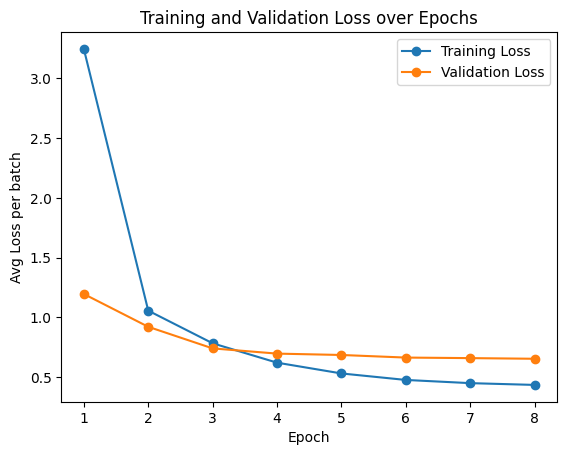

In [22]:
#importing  matplotlib library for plotting and visualzing the values.
import matplotlib.pyplot as plt

# Plot the loss curves
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')

plt.plot(range(1, num_epochs + 1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Avg Loss per batch')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Visualization of the Pearson Values over epoch

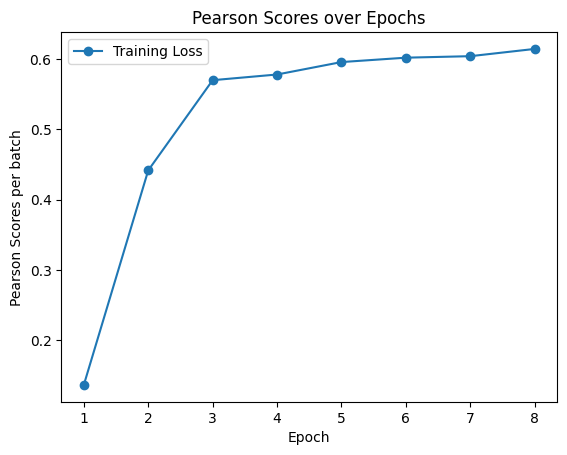

In [23]:
import matplotlib.pyplot as plt
# plotting and visualzing the loss curves.
plt.plot(range(1, num_epochs + 1), pearson_scores, marker='o', label='Training Loss')

# plt.plot(range(1, num_epochs + 1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Pearson Scores per batch')
plt.title('Pearson Scores over Epochs')
plt.legend()
plt.show()

## 4. Evaluation on test data

In [24]:
#Defining function predict() to predit the model
def predict(model, data_loader):
  model.eval() #model.eval() setting the model into evaluation mode to ensure stable pridiction.
  overall_pred, overall_true = [], [] #lists will be storing the prediction and true value of for all the batches.
  with torch.no_grad(): # temporarily desabling the graidant calculation to reduce the memory consumption.
    val_loss_sum=0
    for idx, (ids, att_msks, y) in enumerate(data_loader): # iteration through the dataset where data_loader providing the data batches, ids is the inputIDs, att_mask is corrsponding which toekn should be used or ignore, and y is the true lable for the current batch.
      ids, att_msks, y = ids.to(device), att_msks.to(device), y.to(device) #moving the data to the device which is using for the computaion.
      y_pred = model(ids, att_msks) #model is running and  generating the prediction


      y_pred, y = torch.squeeze(y_pred).cpu().numpy().tolist(), torch.squeeze(y).cpu().numpy().tolist() # torch.seweeze () ensuring the shape of the tensor is appropriate for further process, .cpu() shifting the GPU to CPU bcs NumPy calculation cannot be done on GPU,.NumPy()converting the tensor into NumPy array and .tolist() is converting the NumPy array into Python list.
      overall_pred.append(y_pred)
      overall_true.append(y)

  return overall_pred, overall_true


# Pridiction on Test Dataset

<ipython-input-26-632d7ec91f92>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("BERT_Multilingual_0.25_overall_loss.pth"), strict=False)


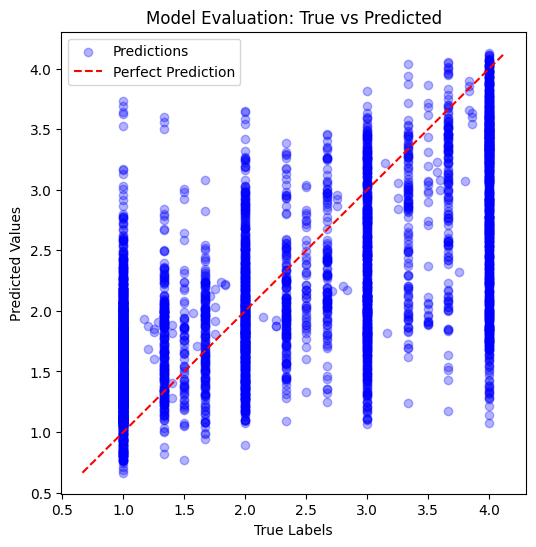

Mean Pearson correlation for test dataset: 0.5606


In [26]:
# Loading the test data
test_data = pd.read_csv('/content/drive/MyDrive/enriched_test_data.csv')
test_data = test_data[test_data['lang1'] == test_data['lang2']]  # Filtering rows where lang1 == lang2


# Preprocessing the test data
test_data = test_data.rename(columns={'text1': 'merge1', 'text2': 'merge2'})

# Createing DataLoader for the test dataset
test_data_loader = get_data_loader(test_data, False)

# Loading the model weights
model.load_state_dict(torch.load("BERT_Multilingual_0.25_overall_loss.pth"), strict=False)
model.to(device)

# Get predictions on the test dataset
test_pred_overall, test_true_overall = predict(model, test_data_loader)

# Converting lists to NumPy arrays for indexing
test_pred_overall = np.array(test_pred_overall)
test_true_overall = np.array(test_true_overall)

# Calculating Pearson correlations for each aspect
pearson_correlations = calculate_pearson_per_aspect(test_pred_overall, test_true_overall)
import matplotlib.pyplot as plt
import numpy as np

# Createing scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(test_true_overall, test_pred_overall, alpha=0.3, color='b', label='Predictions')

# Plot a line for perfect predictions (y = x)
min_val = min(test_true_overall.min(), test_pred_overall.min())
max_val = max(test_true_overall.max(), test_pred_overall.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')
# Adding labels and title
plt.xlabel('True Labels')
plt.ylabel('Predicted Values')
plt.title('Model Evaluation: True vs Predicted')
plt.legend()

# Show plot
plt.show()

# Calculate and print the mean Pearson correlation across all aspects
curr_pearson = np.mean(pearson_correlations)
print(f"Mean Pearson correlation for test dataset: {curr_pearson:.4f}")


In [27]:
pearson_correlations = calculate_pearson_per_aspect(test_pred_overall, test_true_overall)#calculate_pearson_per_aspect() fuction for computing pearson correlation for each aspect and assigning to the pearson_correlation object.
for i, r in enumerate(pearson_correlations):
        print(f"Pearson correlation for aspect {i+1}: {r:.4f}")

curr_pearson = np.mean(pearson_correlations)#np.mean() calculating the mean of the correlation of all 7 aspects and assigning to the curr_pearson object.
print(f"Mean Pearson correlation for test dataset: {curr_pearson:.4f}")

Pearson correlation for aspect 1: 0.6169
Pearson correlation for aspect 2: 0.7699
Pearson correlation for aspect 3: 0.2524
Pearson correlation for aspect 4: 0.7447
Pearson correlation for aspect 5: 0.7836
Pearson correlation for aspect 6: 0.3400
Pearson correlation for aspect 7: 0.4171
Mean Pearson correlation for test dataset: 0.5606


In [28]:
test_pred_overall

array([[1.12025046, 1.76466012, 1.34943998, ..., 1.75495875, 1.43369985,
        1.30833733],
       [0.93070114, 1.49389148, 1.20385337, ..., 1.46675837, 1.30220377,
        1.16894329],
       [0.94853008, 1.51158476, 1.20264351, ..., 1.48423398, 1.30475187,
        1.17532909],
       ...,
       [0.84903485, 1.37679565, 1.13846457, ..., 1.34489262, 1.23724055,
        1.10647476],
       [2.20063043, 3.1830256 , 1.99168277, ..., 3.26463223, 1.92745757,
        1.9661237 ],
       [2.42476392, 3.36626148, 2.06017995, ..., 3.45602822, 2.05983615,
        2.0837822 ]])